# Prepare some things
## Load some modules

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.utils import to_categorical

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics
from scipy.cluster import hierarchy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../')
from models import get_autoencoder_model, get_dec_model, get_vade_models, compute_p, compute_delta
from clustering_metrics import evaluate_model, evaluate_clustering
from draw_embeddings import draw_embeddings, draw_matched_labels, draw_multiple_labels

In [3]:
# Disable warnings output (TSNE outputs one very time)
import warnings
warnings.filterwarnings('ignore')

## Load the metabolomic data
(alrady min-max normalized)

In [4]:
metabol_exprs = pd.read_csv("ExposomeChallengeData/datasets/metabol_joint_exprs_minmax.csv", index_col=0)
metabol_exprs.head()

,serum_metab_1,serum_metab_2,serum_metab_3,serum_metab_4,serum_metab_5,serum_metab_6,serum_metab_7,serum_metab_8,serum_metab_9,serum_metab_10,...,urine_metab_35,urine_metab_36,urine_metab_37,urine_metab_38,urine_metab_39,urine_metab_40,urine_metab_41,urine_metab_42,urine_metab_43,urine_metab_44
430,0.224542,0.205024,0.490470,0.653163,0.515652,0.483009,0.249523,0.340524,0.400406,0.574663,...,0.485001,0.628204,0.489431,0.640612,0.391376,0.665946,0.848047,0.360177,0.587031,0.605114
1187,0.402503,0.549489,0.828354,0.323912,0.431621,0.491824,0.376192,0.348330,0.213731,0.308797,...,0.469040,0.816605,0.441328,0.000000,0.494475,0.696170,0.413698,0.396026,0.572658,0.619732
940,0.402503,0.556896,0.706195,0.534558,0.544173,0.514375,0.397976,0.856991,0.358113,0.315096,...,0.469738,0.627037,0.519383,0.000000,0.326659,0.645060,0.841829,0.000000,0.653218,0.665950
936,0.462293,0.578889,0.451112,0.448921,0.492050,0.553183,0.372429,0.544806,0.388943,0.545676,...,0.457602,0.738061,0.290234,0.177238,0.451808,0.487007,0.759121,0.000000,0.678092,0.729031
788,0.247137,0.571595,0.568414,0.417697,0.432269,0.553183,0.531642,0.534388,0.536561,0.704749,...,0.452021,0.639165,0.329798,0.354477,0.250210,0.702331,0.778121,0.345500,0.554585,0.661642


In [5]:
metabol_exprs = metabol_exprs.to_numpy()

In [6]:
print("Shape of the data set:", metabol_exprs.shape)
print("Number of data points:", np.multiply(*metabol_exprs.shape))

Shape of the data set: (1152, 221)
Number of data points: 254592


## Load the categorical variables
(subset of phenotype and covariates data, already codified)

In [7]:
phenotype_cat = pd.read_csv("ExposomeChallengeData/datasets/phenotype_cat.csv", index_col=0)
covariates_cat = pd.read_csv("ExposomeChallengeData/datasets/covariates_cat.csv", index_col=0)
classes = pd.concat([phenotype_cat, covariates_cat], axis=1)
classes.head()

,birth_weight,iq,behaviour,asthma,bmi,cohort,age,sex,education,native,parity
1,3,0,3,0,1,3,1,0,1,2,0
2,3,1,3,0,1,3,2,0,2,2,1
3,3,0,3,1,3,3,1,0,2,2,1
4,1,2,3,0,1,1,4,1,0,2,1
5,3,0,1,0,1,2,4,0,0,2,0


In [8]:
print("Number of class variables:", classes.shape[1])

Number of class variables: 11


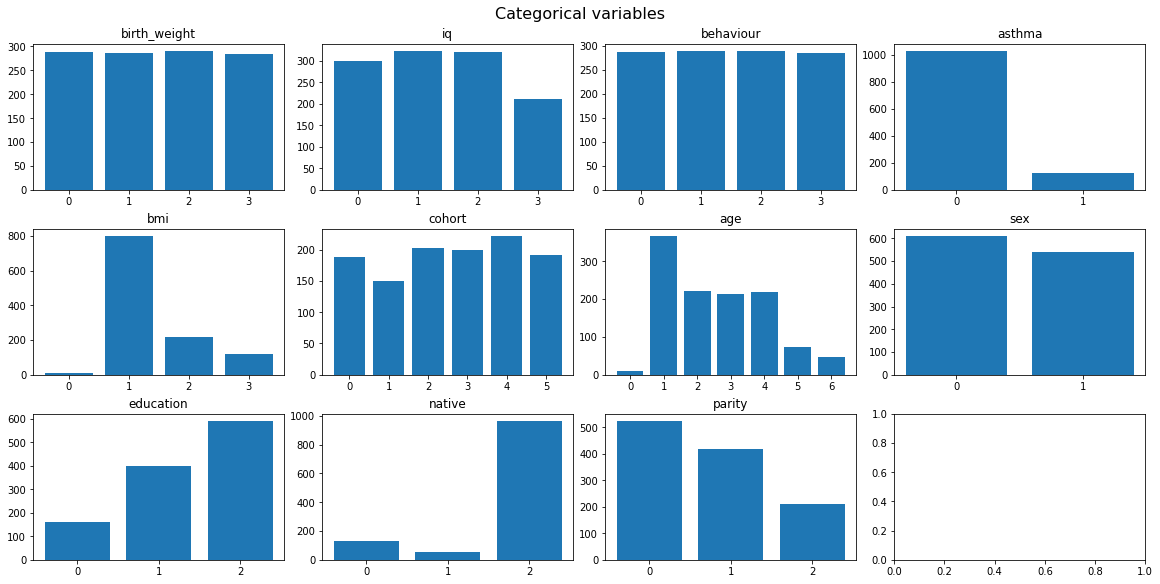

In [9]:
fig, axes = plt.subplots(3, 4, figsize=(16, 8), constrained_layout=True)
i = 0
for row in axes:
    for ax in row:
        counts = classes.iloc[:,i].value_counts()
        index = counts.index
        ax.bar(index, counts)
        ax.set_xticks(index)
        ax.title.set_text(classes.columns[i])
        i += 1
        if i == classes.shape[1]:
            break
fig.suptitle("Categorical variables", fontsize=16)
plt.show()

# Deep clustering models

In [48]:
categorical_variables = {2: ["asthma", "sex"],
                         3: ["education", "native", "parity"],
                         4: ["birth_weight", "iq", "behaviour"],
                         6: ["cohort"],
                         7: ["age"]}

true_labels = {}
for k, variables in categorical_variables.items():
    true_labels[k] = {var: classes.loc[:,var] for var in variables}

cluster_labels = []
results = []

## DEC

In [49]:
def dec_callback(epoch, logs):
    global p
    global c_last
    
    if (epoch+1) % SCHEDULE == 0:
        q = model_dec.soft_assignment(metabol_exprs)
        p = compute_p(q)
        
        c_new = q.numpy().argmax(1)
        delta = compute_delta(c_new, c_last)
        c_last = np.copy(c_new)
        # print(f"Delta: {delta:.3f}")
        if (delta < DELTA_THRESHOLD):
            model_dec.stop_training = True
            
callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=dec_callback)

In [50]:
INPUT_DIM = metabol_exprs.shape[1]  # 221
INTERMEDIATE_DIMS = (64, 32)

EPOCHS_PRETRAIN = 100
LEARNING_RATE_PRETRAIN = 1
MOMENTUM_PRETRAIN = 0.5

EPOCHS_FINETUNE = 100
LEARNING_RATE_FINETUNE = 1e-4
MOMENTUM_FINETUNE = 0.9

BATCH_SIZE = 32
SCHEDULE = 10
DELTA_THRESHOLD = 0.001

K=2 - Pretraining AE [loss: 0.0158] - Fine-tunning DEC
[loss: 1.4773]
asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.719']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.719']
K=3 - Pretraining AE [loss: 0.0157] - Fine-tunning DEC
[loss: 3.0773]
education ['Acc: 0.513', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.645']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.645']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.645']
K=4 - Pretraining AE [loss: 0.0138] - Fine-tunning DEC
[loss: 4.7701]
birth_weight ['Acc: 0.286', 'ARI: 0.003', 'AMI: 0.003', 'Sil: 0.452']
iq ['Acc: 0.293', 'ARI: -0.002', 'AMI: 0.002', 'Sil: 0.452']
behaviour ['Acc: 0.280', 'ARI: 0.001', 'AMI: 0.001', 'Sil: 0.452']
K=6 - Pretraining AE [loss: 0.0139] - Fine-tunning DEC
[loss: 6.7040]
cohort ['Acc: 0.217', 'ARI: 0.005', 'AMI: 0.003', 'Sil: 0.399']
K=7 - Pretraining AE [loss: 0.0128] - Fine-tunning DEC
[loss: 7.8872]
age ['Acc: 0.319', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.291']


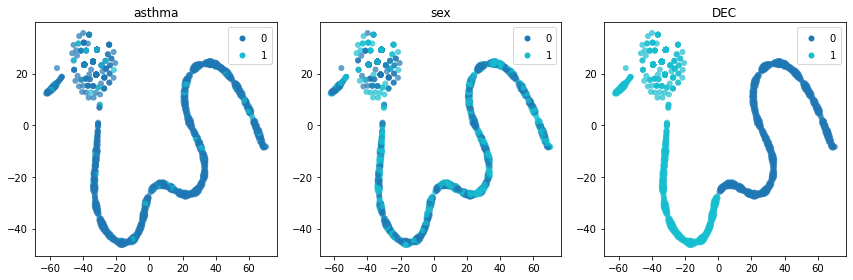

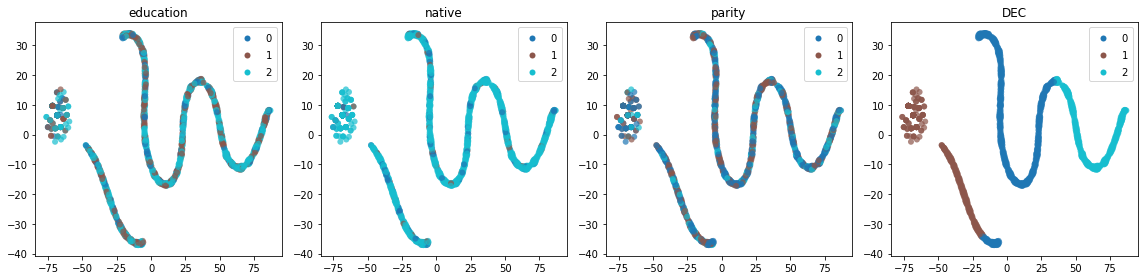

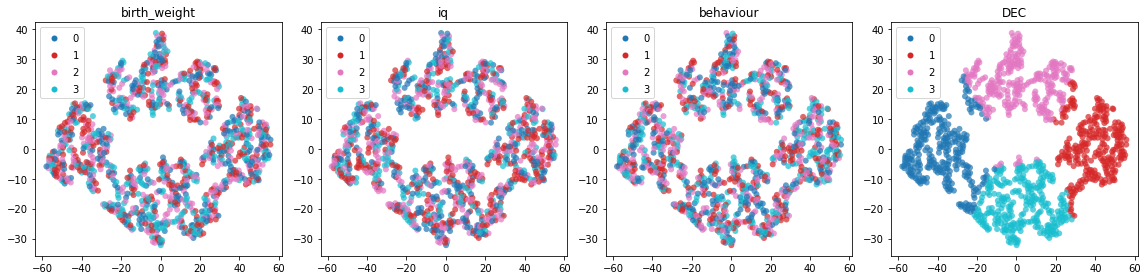

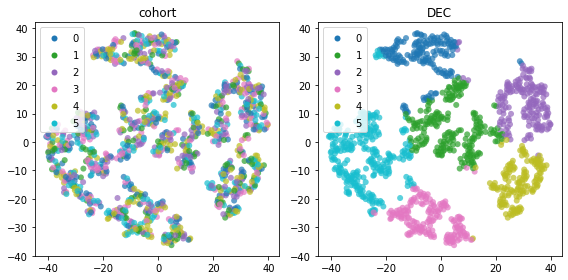

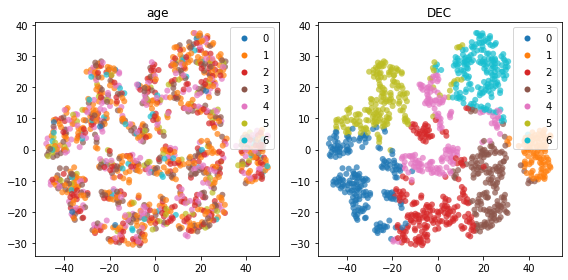

In [51]:
rl_method = "DEC"
clust_method = "K-Means"

for k, variables in categorical_variables.items():
    LATENT_DIM = k
    N_CLUSTERS = k
    
    # Construct and pretrain AE
    print(f"K={k} - Pretraining AE", end=" ")
    model_ae = get_autoencoder_model(INPUT_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_PRETRAIN,
                                     momentum=MOMENTUM_PRETRAIN)
    loss = "mse"
    model_ae.compile(optimizer=optimizer, loss=loss)
    history = model_ae.fit(metabol_exprs, metabol_exprs,
                           epochs=EPOCHS_PRETRAIN,
                           batch_size=BATCH_SIZE,
                           verbose=0)
    print(f"[loss: {history.history['loss'][-1]:.4f}]", end=" ")
    
    # Construct DEC
    print("- Fine-tunning DEC", end=" ")
    model_dec = get_dec_model(model_ae.encoder, N_CLUSTERS)
    
    # Initialize parameters
    z_dec = model_dec.encode(metabol_exprs)
    kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
    kmeans.fit(z_dec)
    for weight in model_dec.trainable_weights:
        if weight.name == "centroids:0":
            weight.assign(K.constant(kmeans.cluster_centers_))

    p = compute_p(to_categorical(kmeans.labels_))
    c_last = kmeans.labels_

    # Fine-tune the model
    optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_FINETUNE, 
                                     momentum=MOMENTUM_FINETUNE)
    model_dec.compile(optimizer=optimizer)
    history = model_dec.fit(metabol_exprs, p,
                            epochs=EPOCHS_FINETUNE,
                            batch_size=BATCH_SIZE,
                            callbacks = callback,
                            verbose=0)
    print(f"[loss: {history.history['loss'][-1]:.4f}]")
    
    # Compute the cluster assignments
    c_dec = model_dec.classify(metabol_exprs)
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": c_dec})
    
    # Compute metrics
    z_dec = model_dec.encode(metabol_exprs)
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(z_dec, labels, c_dec, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)
    
    # Draw the embeddings
    tsne = TSNE(n_components=2, init='pca')
    z_dec_tsne = tsne.fit_transform(z_dec)

    labels = true_labels[k].copy()
    labels.update({rl_method: c_dec})
    draw_multiple_labels(z_dec_tsne, labels)

## VaDE

In [52]:
INPUT_DIM = metabol_exprs.shape[1]  # 221
INTERMEDIATE_DIMS = (64, 32)

EPOCHS_PRETRAIN = 20
LEARNING_RATE_PRETRAIN = 1
MOMENTUM_PRETRAIN = 0.9

EPOCHS_FINETUNE = 50
LEARNING_RATE_FINETUNE = 1e-5
MOMENTUM_FINETUNE = 0.9

BATCH_SIZE = 32
SCHEDULE = 10

In [53]:
def scheduler(epoch, lr):
    if (epoch+1) % SCHEDULE == 0:
        lr = lr * 0.9
    return lr

callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),]

K=2 - Pretraining AE WARNING:tensorflow:Gradients do not exist for variables ['z_logvar/kernel:0', 'z_logvar/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?
[loss: 0.6471] - Fine-tunning VaDE [loss: 145.1579]
asthma ['Acc: 0.893', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.322']
sex ['Acc: 0.530', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.322']
K=3 - Pretraining AE WARNING:tensorflow:Gradients do not exist for variables ['z_logvar/kernel:0', 'z_logvar/bias:0'] when minimizing the loss. If you're using `model.compile()`, did you forget to provide a `loss`argument?
[loss: 0.6451] - Fine-tunning VaDE [loss: 145.3407]
education ['Acc: 0.513', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.220']
native ['Acc: 0.838', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.220']
parity ['Acc: 0.455', 'ARI: 0.000', 'AMI: 0.000', 'Sil: 0.220']
K=4 - Pretraining AE WARNING:tensorflow:Gradients do not exist for variables ['z_logvar/kernel:0', 'z_logvar/bias:0'] when minimiz

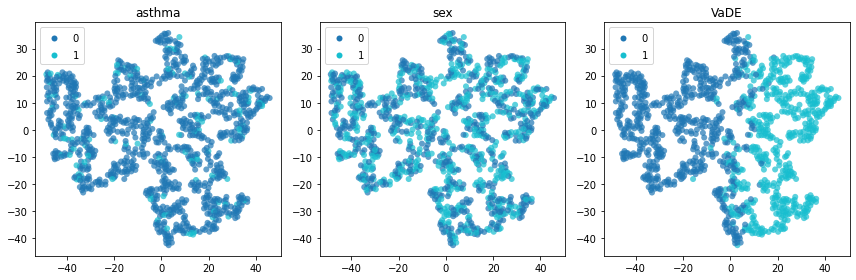

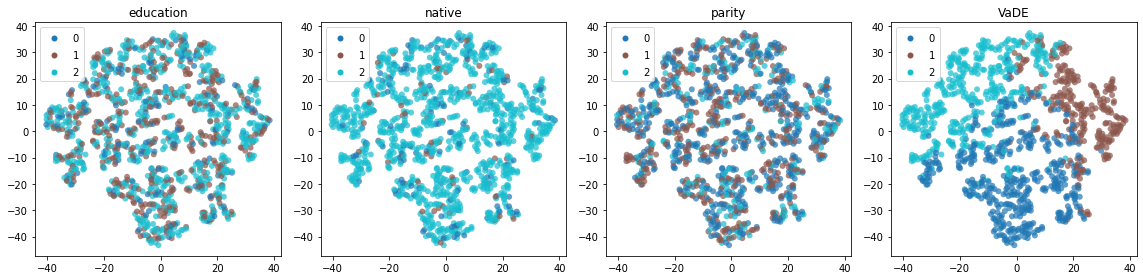

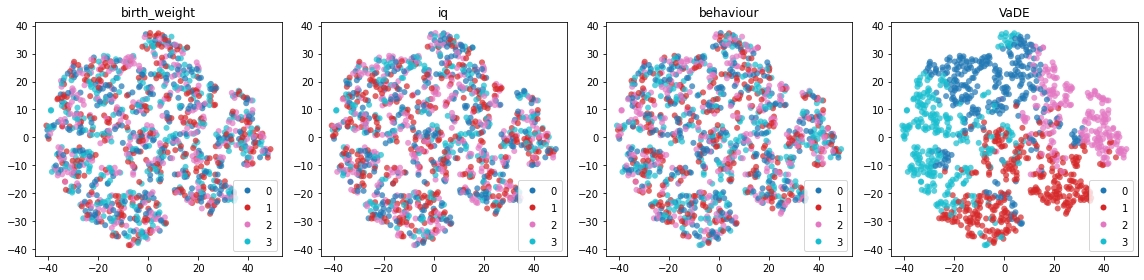

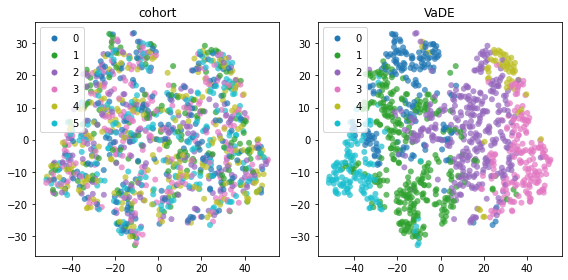

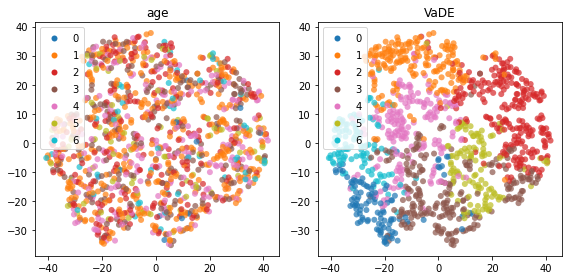

In [54]:
rl_method = "VaDE"
clust_method = "GMM"

for k, variables in categorical_variables.items():
    LATENT_DIM = k
    N_CLUSTERS = k
    
    # Construct and train the VaDE model.
    # If loss == NaN: retry.
    while True:
        # Construct models and pretrain AE
        print(f"K={k} - Pretraining AE", end=" ")
        model_pretrain, model_vade = get_vade_models(N_CLUSTERS, INPUT_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
        optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_PRETRAIN,
                                         momentum=MOMENTUM_PRETRAIN)
        loss = keras.losses.BinaryCrossentropy()
        model_pretrain.compile(optimizer=optimizer, loss=loss)
        history = model_pretrain.fit(metabol_exprs, metabol_exprs,
                                     epochs=EPOCHS_PRETRAIN,
                                     batch_size=BATCH_SIZE,
                                     verbose=0)
        print(f"[loss: {history.history['loss'][-1]:.4f}]", end=" ")

        # Initialize parameters
        z_vade = model_vade.encode_only_mu(metabol_exprs)
        gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag', n_init=30)
        gmm.fit(z_vade)
        for weight in model_vade.trainable_weights:
            if weight.name == "pi:0":
                weight.assign(K.log(K.constant(gmm.weights_)))
            elif weight.name == "mu:0":
                weight.assign(K.constant(gmm.means_))
            elif weight.name == "logvar:0":
                weight.assign(K.log(K.constant(gmm.covariances_)))

        # Fine-tune the model
        print("- Fine-tunning VaDE", end=" ")
        optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_FINETUNE,
                                         momentum=MOMENTUM_FINETUNE)
        model_vade.compile(optimizer=optimizer)
        history = model_vade.fit(metabol_exprs,
                                 epochs=EPOCHS_FINETUNE,
                                 batch_size=BATCH_SIZE,
                                 callbacks = callback,
                                 verbose=0)
        #If loss == NaN: retry.
        if np.isnan(history.history['loss'][-1]):
            print("[Got NaN as loss. Retrying.]")
            continue
        else:
            print(f"[loss: {history.history['loss'][-1]:.4f}]")
            break

    # Compute the cluster assignments
    c_vade = model_vade.classify(metabol_exprs).numpy()
    cluster_labels.append({"rl_method": rl_method, 
                           "clust_method": clust_method, 
                           "n_clusters": k, 
                           "labels": c_vade})
    
    # Compute metrics
    z_vade = model_vade.encode_only_mu(metabol_exprs)
    for variable, labels in true_labels[k].items():
        metrics = evaluate_clustering(z_vade, labels, c_vade, False)
        print(variable, [f'{metric}: {value:.3f}' for metric, value in metrics.items()])
        result = {"rl_method": rl_method, 
                  "clust_method": clust_method, 
                  "n_clusters": k, 
                  "variable": variable}
        result.update(metrics)
        results.append(result)
    
    # Draw the embeddings
    tsne = TSNE(n_components=2, init='pca')
    z_vade_tsne = tsne.fit_transform(z_vade)

    labels = true_labels[k].copy()
    labels.update({rl_method: c_vade})
    draw_multiple_labels(z_vade_tsne, labels)

# Results

## Metrics

In [66]:
results = pd.DataFrame(results)
# Save the metrics on a CSV file
results.to_csv("results/dc_metrics.csv", index=False)

results_mean = results.set_index(["rl_method","clust_method"]).groupby(level=[0,1]).mean()
results_mean = results_mean.iloc[:,1:]
results_mean.style.background_gradient(axis=0, cmap="cividis", text_color_threshold=0.3, subset=['Acc','ARI','AMI','Sil']).format('{:.2f}', subset=['Acc','ARI','AMI','Sil'])

,,Acc,ARI,AMI,Sil
rl_method,clust_method,,,,
DEC,K-Means,0.46,0.00,0.00,0.54
VaDE,GMM,0.46,0.00,0.00,0.21


In [56]:
results.style.background_gradient(axis=0, cmap="cividis", text_color_threshold=0.3, subset=['Acc','ARI','AMI','Sil']).format('{:.2f}', subset=['Acc','ARI','AMI','Sil'])

,rl_method,clust_method,n_clusters,variable,Acc,ARI,AMI,Sil
0,DEC,K-Means,2,asthma,0.89,0.00,0.00,0.72
1,DEC,K-Means,2,sex,0.53,0.00,0.00,0.72
2,DEC,K-Means,3,education,0.51,0.00,0.00,0.65
3,DEC,K-Means,3,native,0.84,0.00,0.00,0.65
4,DEC,K-Means,3,parity,0.45,0.00,0.00,0.65
5,DEC,K-Means,4,birth_weight,0.29,0.00,0.00,0.45
6,DEC,K-Means,4,iq,0.29,-0.00,0.00,0.45
7,DEC,K-Means,4,behaviour,0.28,0.00,0.00,0.45
8,DEC,K-Means,6,cohort,0.22,0.00,0.00,0.40
9,DEC,K-Means,7,age,0.32,0.00,0.00,0.29


There is no match between any of the clusters found and the categorical data. The high accuracy values on the variables "asthma" and "native" are due to there being a groups which contains the majority of the observations, so a random assignment would also get a high accuracy.

## Compare assignments

In [67]:
cluster_labels = pd.DataFrame(cluster_labels)

# Save the assignments on a CSV file
pd.DataFrame(cluster_labels).to_csv("results/dc_assignments.csv", index=False)

K=2 ['Acc: 0.761', 'ARI: 0.272', 'AMI: 0.202', 'Sil: 0.310']
K=3 ['Acc: 0.607', 'ARI: 0.233', 'AMI: 0.290', 'Sil: 0.208']
K=4 ['Acc: 0.493', 'ARI: 0.216', 'AMI: 0.281', 'Sil: 0.069']
K=6 ['Acc: 0.446', 'ARI: 0.202', 'AMI: 0.306', 'Sil: 0.060']
K=7 ['Acc: 0.480', 'ARI: 0.264', 'AMI: 0.365', 'Sil: 0.002']


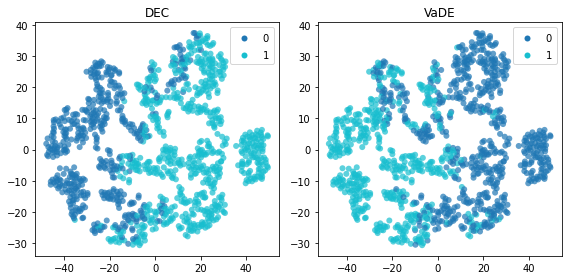

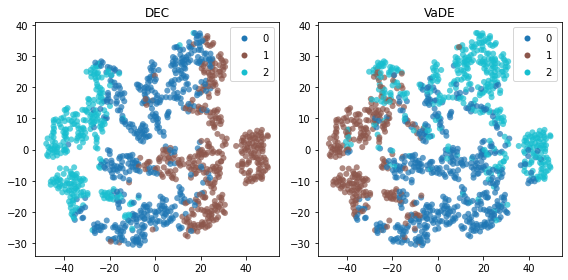

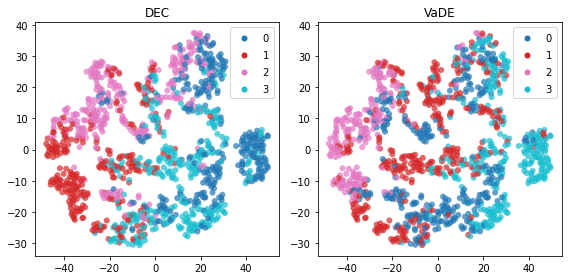

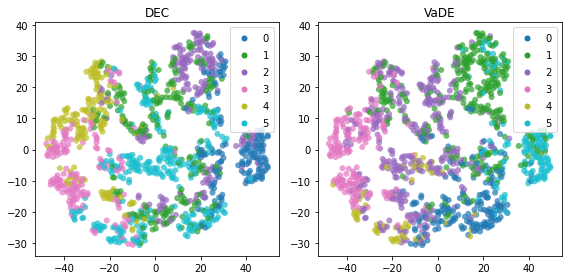

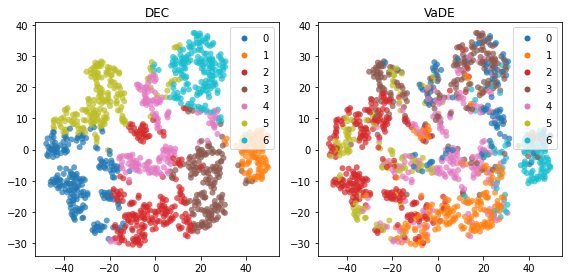

In [72]:
for k in categorical_variables.keys():
    clusters = cluster_labels[cluster_labels.n_clusters==k]
    labels = {clusters.rl_method[i]: clusters.labels[i] for i in clusters.index}
    draw_multiple_labels(z_dec_tsne, labels, max_cols=6)
    metrics = evaluate_clustering(z_dec_tsne, labels["DEC"], labels["VaDE"], False)
    print(f'K={k}', [f'{metric}: {value:.3f}' for metric, value in metrics.items()])

There seems to be some agreement between both methods, specially for K=2 and K=3.